In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
from google.colab import drive
from zipfile import ZipFile

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import matplotlib.pyplot as plt

In [2]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

batch_size = 64
num_epochs = 10
learning_rate = 1e-3
weight_decay = 1e-4

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
CLS = ['neutral', 'happiness', 'surprise', 'sadness', 'anger', 'disgust', 'fear', 'contempt']
NUM_CLS = len(CLS)
CLS_DICT = {cl:i for i, cl in enumerate(CLS)}
CLS_DICT

{'neutral': 0,
 'happiness': 1,
 'surprise': 2,
 'sadness': 3,
 'anger': 4,
 'disgust': 5,
 'fear': 6,
 'contempt': 7}

In [5]:
def extract_fer_datasets():
    drive.mount('/content/drive')

    base_path = '/content/drive/MyDrive/ml/projekt/fer2013'

    target_dirs_exist = any(os.path.isdir(d) for d in ['FER2013Test', 'FER2013Train', 'FER2013Valid'])

    if not target_dirs_exist:
        zip_file_path = os.path.join(base_path, 'data.zip')
        extract_path = '/content/'

        if os.path.exists(zip_file_path):
            with ZipFile(zip_file_path, 'r') as zip_ref:
                zip_ref.extractall(extract_path)
            print(f"Extracted {zip_file_path} to {extract_path}")
        else:
            print(f"Zip file not found at: {zip_file_path}")
    else:
        print("Dataset already extracted")

In [6]:
class FerPlusDataset(Dataset):
    def __init__(self, split, transform, mode='mv', theta=0.3):
        if os.path.exists('/content/drive/MyDrive/ml/projekt/fer2013/data.zip'):
            self.root = f'FER2013{split}'
        else:
            self.root = f'/content/drive/MyDrive/ml/projekt/fer2013/FER2013{split}'
        self.transform = transform
        self.mode = mode
        self.theta = theta

        column_names = [
            'image_name', 'image_tensor',
            'neutral', 'happiness', 'surprise', 'sadness', 'anger', 'disgust', 'fear', 'contempt',
            'unknown', 'NF'
        ]

        df = pd.read_csv(os.path.join(self.root, 'label.csv'), names=column_names, header=None)
        df = df[['image_name', 'neutral', 'happiness',
                 'surprise', 'sadness', 'anger',
                 'disgust', 'fear', 'contempt']]

        self.labels = df[CLS].values
        self.images = df['image_name'].values

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, self.images[idx])
        img = Image.open(img_path)
        x = self.transform(img)

        p = self.labels[idx]

        if self.mode == 'mv':
            y = torch.tensor(np.argmax(p), dtype = torch.long)

        elif self.mode == 'pld':
            y = torch.tensor(np.random.choice(NUM_CLS, p=p), dtype = torch.long)

        elif self.mode == "cel":
            y = torch.tensor(p, dtype=torch.float32)

        elif self.mode == "ml":
            mask = (p > self.theta)
            y = torch.tensor(mask, dtype=torch.float32)

        else:
            raise ValueError(f"Unknown mode {self.mode}")

        return x, y

In [7]:
train_tf = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])

val_tf = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])

In [8]:
def make_loaders(mode):
    train_ds = FerPlusDataset(split='Train', transform=train_tf, mode=mode)
    val_ds = FerPlusDataset(split='Valid', transform=train_tf, mode=mode)
    test_ds = FerPlusDataset(split='Test', transform=train_tf, mode=mode)

    return (
        DataLoader(train_ds, batch_size=batch_size,
                   shuffle=True, num_workers=1,
                   pin_memory=torch.cuda.is_available()),
        DataLoader(val_ds, batch_size=batch_size,
                   shuffle=False, num_workers=1,
                   pin_memory=torch.cuda.is_available()),
        DataLoader(test_ds, batch_size=batch_size,
                   shuffle=False, num_workers=1,
                   pin_memory=torch.cuda.is_available()),
    )

In [9]:
def make_model():
    model = models.vgg13_bn(weights=models.VGG13_BN_Weights.IMAGENET1K_V1)
    model.classifier[6] = nn.Linear(model.classifier[6].in_features, NUM_CLS)
    return model.to(device)

In [ ]:
def get_loss(mode):
    if mode in ('mv','pld'):
        return nn.CrossEntropyLoss()
    elif mode == 'cel':
        return nn.KLDivLoss(reduction="batchmean")
    elif mode == 'ml':
        return nn.BCEWithLogitsLoss()
    else:
        raise ValueError(f"Unknown mode {mode}")

In [12]:
def run_epoch(model, loader, criterion, optimizer, train=True):
    if train:
        model.train()
        desc="Training"
    else:
        model.eval()
        desc ="Validation"

    loss_total = 0
    correct = 0
    total = 0

    with torch.set_grad_enabled(train):
        for data, target in tqdm(loader, desc=desc):
              data, target = data.to(device), target.to(device)

              if train:
                  optimizer.zero_grad()

              output = model(data)
              loss = criterion(output, target)

              if train:
                  loss.backward()
                  optimizer.step()

              loss_total += loss.item()
              pred = output.argmax(dim=1, keepdim=True)
              correct += pred.eq(target.view_as(pred)).sum().item()
              total += target.size(0)

    avg_loss = loss_total / len(loader)
    accuracy = 100. * correct / total

    return avg_loss, accuracy

In [13]:
def history_plot(train_losses,val_losses,train_accs,val_accs):
      fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
      ax1.plot(train_losses, label='Train Loss')
      ax1.plot(val_losses, label='Val Loss')
      ax1.set_xlabel('Epoch')
      ax1.set_ylabel('Loss')
      ax1.set_title('Training and Validation Loss')
      ax1.legend()
      ax1.grid(True)

      ax2.plot(train_accs, label='Train Acc')
      ax2.plot(val_accs, label='Val Acc')
      ax2.set_xlabel('Epoch')
      ax2.set_ylabel('Accuracy (%)')
      ax2.set_title('Training and Validation Accuracy')
      ax2.legend()
      ax2.grid(True)

      plt.tight_layout()
      plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
      plt.show()


In [14]:
def train_model(mode):
    extract_fer_datasets()

    train_loader, val_loader, test_loader = make_loaders(mode)
    print(f"Train samples: {len(train_loader.dataset)}")
    print(f"Val samples: {len(val_loader.dataset)}")
    print(f"Test samples: {len(test_loader.dataset)}")

    model = make_model()

    criterion = get_loss(mode)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    patience = 3
    best_val_acc = 0
    patience_counter = 0

    checkpoint_path = f'/content/drive/MyDrive/ml/projekt/best_model_{mode}.pth'
    if os.path.exists(checkpoint_path):
        print(f"Loading checkpoint from {checkpoint_path}")
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        best_val_acc = checkpoint['best_val_acc']
        print(f"Resuming from epoch {start_epoch}")

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(num_epochs):
          print(f"\nEpoch {epoch+1}/{num_epochs}")
          print('-'*50)

          train_loss, train_acc = run_epoch(model, train_loader, criterion, optimizer, train=True)
          val_loss, val_acc = run_epoch(model, val_loader, criterion, train=False)

          scheduler.step()

          #historia
          train_losses.append(train_loss)
          val_losses.append(val_loss)
          train_accs.append(train_acc)
          val_accs.append(val_acc)

          print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
          print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
          print(f'Learning Rate: {scheduler.get_last_lr()[0]:.6f}')

          if val_acc > best_val_acc:
                best_val_acc = val_acc
                patience_counter = 0
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'best_val_acc': best_val_acc,
                }, checkpoint_path)
                print(f'New best model saved with val accuracy: {best_val_acc:.2f}%')

          else:
                patience_counter += 1
                if patience_counter >= patience:
                    print("Early stopping")
                    break

    history_plot(train_losses, val_losses, train_accs, val_accs)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset already extracted
Train samples: 28558
Val samples: 3579
Test samples: 3573

Epoch 1/10
--------------------------------------------------


Validation: 100%|██████████| 56/56 [00:16<00:00,  3.49it/s]


Train Loss: 0.9983, Train Acc: 65.68%
Val Loss: 0.8700, Val Acc: 68.26%
Learning Rate: 0.001000
New best model saved with val accuracy: 68.26%

Epoch 2/10
--------------------------------------------------


Validation: 100%|██████████| 56/56 [00:16<00:00,  3.44it/s]


Train Loss: 0.7912, Train Acc: 72.55%
Val Loss: 0.9509, Val Acc: 69.21%
Learning Rate: 0.001000
New best model saved with val accuracy: 69.21%

Epoch 3/10
--------------------------------------------------


Validation: 100%|██████████| 56/56 [00:16<00:00,  3.40it/s]


Train Loss: 0.7039, Train Acc: 75.64%
Val Loss: 0.7168, Val Acc: 75.10%
Learning Rate: 0.001000
New best model saved with val accuracy: 75.10%

Epoch 4/10
--------------------------------------------------


Validation: 100%|██████████| 56/56 [00:16<00:00,  3.48it/s]


Train Loss: 0.6506, Train Acc: 77.37%
Val Loss: 0.7504, Val Acc: 75.19%
Learning Rate: 0.001000
New best model saved with val accuracy: 75.19%

Epoch 5/10
--------------------------------------------------


Validation: 100%|██████████| 56/56 [00:16<00:00,  3.47it/s]


Train Loss: 0.6087, Train Acc: 78.60%
Val Loss: 0.6679, Val Acc: 76.81%
Learning Rate: 0.001000
New best model saved with val accuracy: 76.81%

Epoch 6/10
--------------------------------------------------


Validation: 100%|██████████| 56/56 [00:16<00:00,  3.47it/s]


Train Loss: 0.5884, Train Acc: 79.08%
Val Loss: 0.8758, Val Acc: 73.85%
Learning Rate: 0.001000

Epoch 7/10
--------------------------------------------------


Validation: 100%|██████████| 56/56 [00:16<00:00,  3.45it/s]



Train Loss: 0.5485, Train Acc: 80.68%
Val Loss: 0.6241, Val Acc: 77.95%
Learning Rate: 0.001000
New best model saved with val accuracy: 77.95%

Epoch 8/10
--------------------------------------------------


Validation: 100%|██████████| 56/56 [00:16<00:00,  3.48it/s]



Train Loss: 0.5256, Train Acc: 81.20%
Val Loss: 1.7993, Val Acc: 63.09%
Learning Rate: 0.001000

Epoch 9/10
--------------------------------------------------


Validation: 100%|██████████| 56/56 [00:16<00:00,  3.47it/s]



Train Loss: 0.5108, Train Acc: 81.74%
Val Loss: 0.7055, Val Acc: 76.70%
Learning Rate: 0.001000

Epoch 10/10
--------------------------------------------------


Validation: 100%|██████████| 56/56 [00:16<00:00,  3.49it/s]



Train Loss: 0.4838, Train Acc: 82.69%
Val Loss: 0.6071, Val Acc: 79.66%
Learning Rate: 0.000100
New best model saved with val accuracy: 79.66%


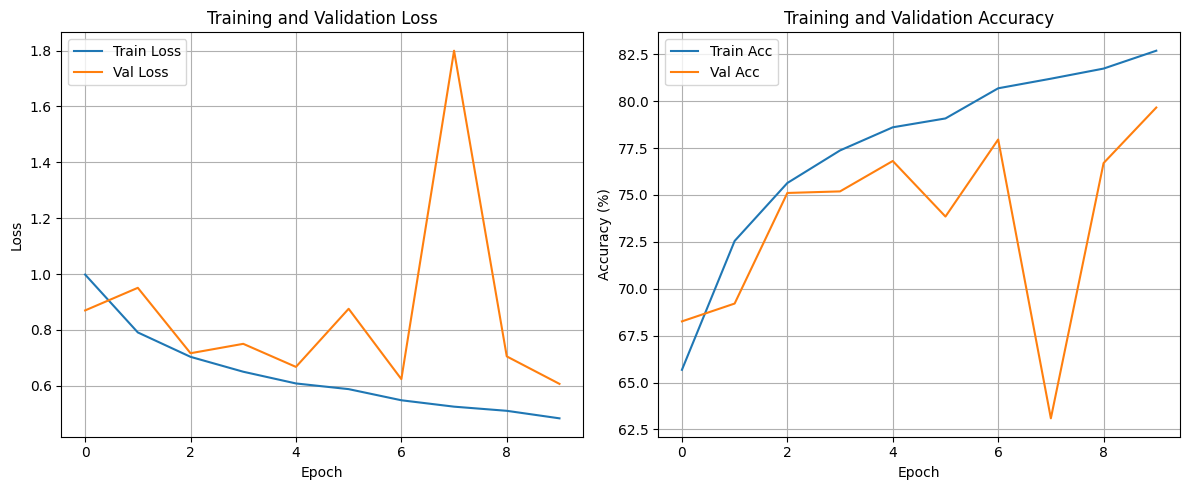

In [ ]:
train_model('mv')

In [ ]:
train_model('mv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset already extracted
Train samples: 28558
Val samples: 3579
Test samples: 3573

Epoch 1/10
--------------------------------------------------


Training:  53%|█████▎    | 235/447 [03:31<03:08,  1.12it/s]